# Does a certain area (location) have higher/lower adoption rates?

In [14]:
import pandas as pd
import numpy as np
import hvplot.pandas
import requests
import petpy
import pprint

from matplotlib import pyplot as plt
from config import api_key as api_key
from config import api_secret as api_secret
from config import geoapify_key

In [2]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,edinburgh of the seven seas,-37.0676,-12.3116,51.15,53,67,22.73,SH,1690425679
1,1,suva,-18.1416,178.4415,67.48,94,100,6.91,FJ,1690425730
2,2,port macquarie,-31.4333,152.9167,69.89,53,0,8.84,AU,1690425730
3,3,mainvilliers,48.4500,1.4561,63.88,87,95,7.00,FR,1690425730
4,4,ilulissat,69.2167,-51.1000,46.42,66,0,4.61,GL,1690425730


## Retrive data from APIs

**API/Resources:**
- [Adopt a Pet API](https://www.adoptapet.com/public/apis/pet_list.html)
- [Pet Finder API](https://www.petfinder.com/developers/)


In [3]:
pf = petpy.Petfinder(key=api_key, secret=api_secret)

In [4]:
#2018 - 2023 adopted dogs
adoptable_dogs = pf.animals(animal_type = 'dog', status='adoptable', location='NC', pages=None, sort='recent', after_date='2017-12-31', before_date='2022-01-01', results_per_page=100, return_df=True)
print('Adoptable dogs: '+ str(len(adoptable_dogs['id'].unique())))

#2018 - 2023 adoptable cats
adoptable_cats = pf.animals(animal_type = 'cat', status='adoptable', location='NC', pages=None, sort='recent', after_date='2017-12-31', before_date='2022-01-01', results_per_page=100, return_df=True)
print('Adoptable cats: '+ str(len(adoptable_cats['id'].unique())))

Adoptable dogs: 284
Adoptable cats: 332


In [5]:
#Clean Data
to_drop = ['url', 'species', 'age', 'gender', 'size', 'coat', 'tags', 
           'animal_id', 'animal_type', 'primary_photo_cropped', 'photos', 
           'videos', 'primary_photo_cropped.full', 'primary_photo_cropped.large', 
           'primary_photo_cropped.small', 'primary_photo_cropped.medium','name', 
           'description', 'organization_animal_id', 'contact.email', 'contact.phone', 
           'breeds.primary', 'breeds.secondary', 'breeds.mixed', 'breeds.unknown',
           'colors.primary', 'colors.secondary', 'colors.tertiary',
           'attributes.spayed_neutered', 'attributes.declawed', 'attributes.special_needs',
           'attributes.shots_current', 'attributes.house_trained',
           'environment.children', 'environment.dogs', 'environment.cats']

adoptable_dogs.drop(to_drop, inplace = True, axis=1)
adoptable_cats.drop(to_drop, inplace = True, axis=1)


In [6]:
#Drop last column - duplicate organization ID
adoptable_dogs_clean = adoptable_dogs.iloc[: , :-1]
adoptable_cats_clean = adoptable_cats.iloc[: , :-1]

#Rename Columns
new_columns = {
    'id':'ID',
    'organization_id':'Organization ID',
    'type':'Type',
    'status':'Status',
    'status_changed_at':'Status Changed',
    'published_at':'Published',
    'distance':'Distance',
    'contact.address.address1':'Address 1',
    'contact.address.address2':'Address 2',
    'contact.address.city':'City',
    'contact.address.state':'State',
    'contact.address.postcode':'Zip Code',
    'contact.address.country':'Country'
}

adoptable_dogs_clean.rename(columns=new_columns, inplace=True)
adoptable_cats_clean.rename(columns=new_columns, inplace=True)

#Print New DFs
print(adoptable_dogs_clean.head())
adoptable_cats_clean.head()

         ID Organization ID Type     Status            Status Changed  \
0  54050425           SC170  Dog  adoptable  2021-12-30T02:22:21+0000   
1  54045877            NC11  Dog  adoptable  2022-12-01T17:16:46+0000   
2  54031867           NC419  Dog  adoptable  2022-03-07T17:20:52+0000   
3  54022085          NC1172  Dog  adoptable  2021-12-27T20:21:46+0000   
4  54005089           NC698  Dog  adoptable  2021-12-24T20:42:08+0000   

                  Published  Distance          Address 1  \
0  2021-12-30T02:22:21+0000   83.3665  1705 Adoption Way   
1  2021-12-29T19:47:02+0000   95.3447        PO Box 1884   
2  2021-12-28T17:13:33+0000   81.6870               None   
3  2021-12-27T20:21:46+0000   49.6520               None   
4  2021-12-24T20:42:02+0000   90.9259        PO Box 2746   

                              Address 2         City State Zip Code Country  
0                                  None   Darlington    SC    29532      US  
1  Adoption Center at 417 Kirksey Drive    M

,ID,Organization ID,Type,Status,Status Changed,Published,Distance,Address 1,Address 2,City,State,Zip Code,Country
0,54071180,VA609,Cat,adoptable,2022-01-01T02:29:03+0000,2022-01-01T02:29:03+0000,79.8959,None,None,Stuart,VA,24171,US
1,53995527,NC1111,Cat,adoptable,2021-12-23T18:36:30+0000,2021-12-23T18:36:28+0000,85.1958,None,None,Raleigh,NC,27616,US
2,53995421,NC1111,Cat,adoptable,2021-12-23T18:22:53+0000,2021-12-23T18:22:50+0000,85.1958,None,None,Raleigh,NC,27616,US
3,53951752,NC929,Cat,adoptable,2021-12-19T14:59:27+0000,2021-12-19T14:59:27+0000,51.7933,None,None,Burlington,NC,27215,US
4,53890155,NC1070,Cat,adoptable,2021-12-13T20:39:24+0000,2021-12-13T20:39:24+0000,57.8536,None,None,Pineville,NC,28134,US


In [48]:
#Adoptable Dogs in NC from 2018 - 2022
adoptable_dogs_nc = adoptable_dogs_clean.loc[adoptable_dogs_clean['State'] == 'NC']

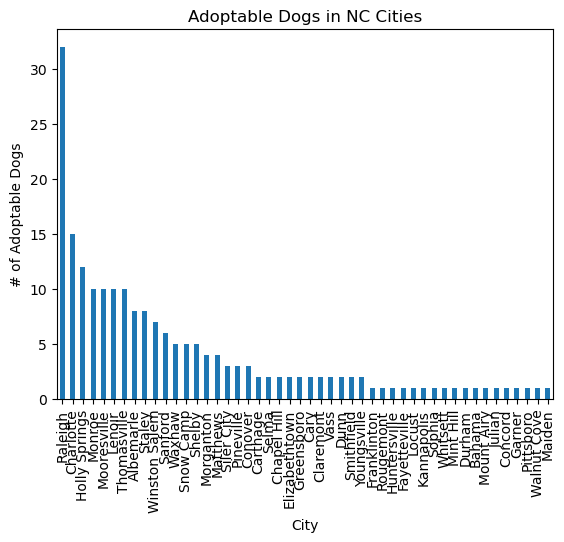

In [9]:
#Bar Graph of adoptable dogs in NC Cities
dog_cities = adoptable_dogs_nc['City'].value_counts()

dog_chart = dog_cities.plot(kind = 'bar', align = "center")
dog_chart.set_xlabel('City')
dog_chart.set_ylabel('# of Adoptable Dogs')
dog_chart.set_title('Adoptable Dogs in NC Cities')

plt.show()

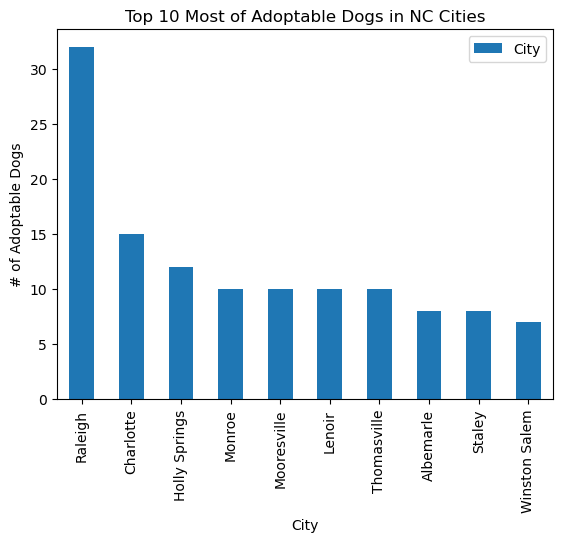

In [46]:
#Bar Graph of top 10 most adoptable dogs in NC Cities
dog_cities_df = pd.DataFrame(dog_cities)

dog_chart_10 = dog_cities_df.head(10).plot(kind = 'bar', align = "center")
dog_chart_10.set_xlabel('City')
dog_chart_10.set_ylabel('# of Adoptable Dogs')
dog_chart_10.set_title('Top 10 Most of Adoptable Dogs in NC Cities')

plt.show()

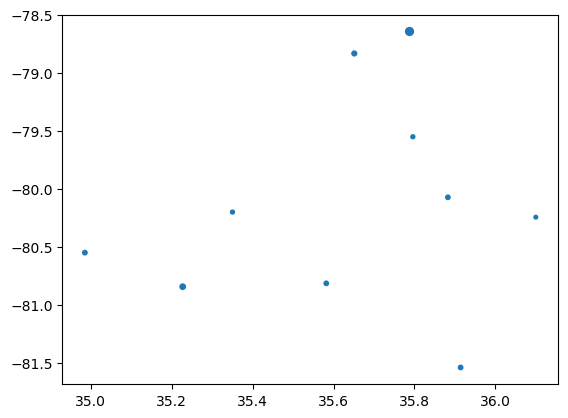

In [61]:
'''
Raleigh: 35.787743, -78.644257
Charlotte: 35.2271, -80.8431
Holly Springs: 35.6513, -78.8336
Monroe: 34.9854, -80.5495
Mooresville: 35.5820, -80.8140
Lenoir: 35.9140, -81.5390
Thomasville: 35.8826, -80.0730
Albemarlele: 35.3501, -80.2001
Staley: 35.7960, -79.5514
Winston Salem: 36.0999, -80.2442
'''

dogs_city_lat =[35.787743, 35.2271, 35.6513, 34.9854, 35.5820,
               35.9140, 35.8826, 35.3501, 35.7960, 36.0999]

dogs_city_lng = [-78.6442, -80.8431, -78.8336, -80.5495, -80.8140,
                 -81.5390, -80.0730, -80.2001, -79.5514, -80.2442]


plt.scatter(dogs_city_lat, dogs_city_lng, s=dog_cities_df.head(10), marker = 'o')
plt.hover()
plt.show()

In [44]:
#Adoptable Cats in NC from 2018 - 2022
adoptable_cats_nc = adoptable_cats_clean.loc[adoptable_cats_clean['State'] == 'NC']

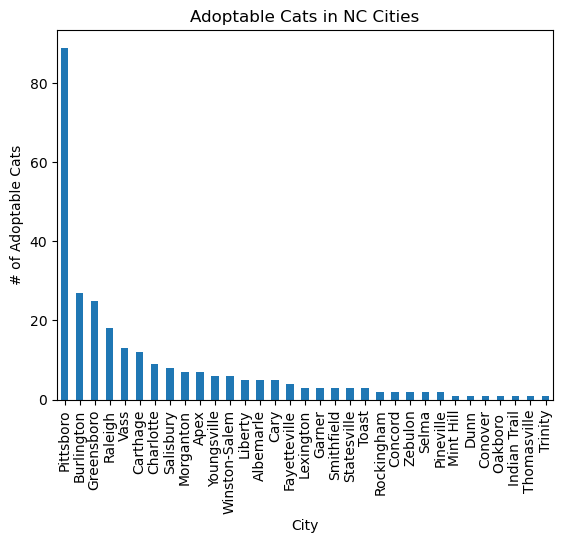

In [45]:
#Bar Graph of adoptable dogs in NC Cities
cat_cities = adoptable_cats_nc['City'].value_counts()

cat_chart = cat_cities.plot(kind = 'bar', align = "center")
cat_chart.set_xlabel('City')
cat_chart.set_ylabel('# of Adoptable Cats')
cat_chart.set_title('Adoptable Cats in NC Cities')

plt.show()

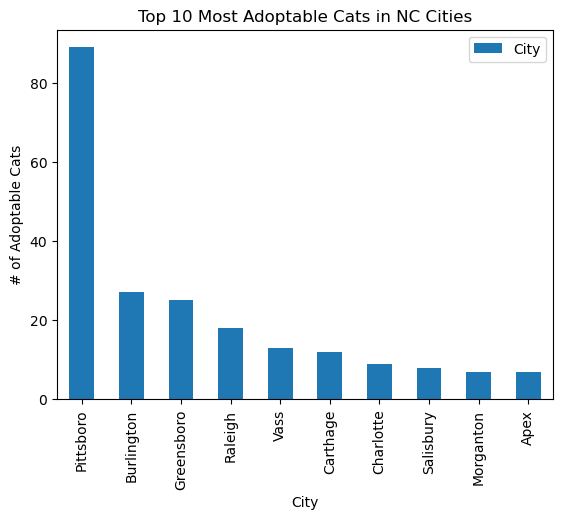

In [47]:
#Bar Graph of Top 10 Most Adoptable Dogs in NC Cities

cat_cities_df = pd.DataFrame(cat_cities)

cat_chart_10 = cat_cities_df.head(10).plot(kind = 'bar', align = "center")
cat_chart_10.set_xlabel('City')
cat_chart_10.set_ylabel('# of Adoptable Cats')
cat_chart_10.set_title('Top 10 Most Adoptable Cats in NC Cities')

plt.show()

In [ ]:
#Adoptable Cats & Dogs in NC from 2018 - 2022
adoptable_cats_dogs = pd.merge(adoptable_cats_nc, adoptable_dogs_nc, on='Status')
adoptable_cats_dogs.head()

'''adoptable_cats_nc = adoptable_cats_clean.loc[adoptable_cats_clean['State'] == 'NC']
adoptable_cats_nc['City'].value_counts()'''